In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from PIL import Image
from skimage import io
from scipy.ndimage import distance_transform_edt as distance

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import segmentation as skimage_seg

%matplotlib inline

In [2]:
# refer to https://discuss.pytorch.org/t/visualize-feature-map/29597/2
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [3]:
def print_min_max(img):
    if isinstance(img, np.ndarray):
        print(f" min value: {img.min()} max value: {img.max()}")
    else:
        raise TypeError

In [4]:
path1 = "/media/syz/PolySeg_old/data/CVC-612/gtpolyp/548.tif"
path2 = "/media/syz/PolySeg_old/data/CVC-612/gtpolyp/213.tif"

demo1 = io.imread(path1, as_gray=True)
demo2 = io.imread(path2, as_gray=True)
demo1 = demo1/255
demo2 = demo2/255
batch_demo = np.stack((demo1, demo2), 0)
print(batch_demo.shape)
print_min_max(demo1)
print_min_max(demo2)

(2, 288, 384)
 min value: 0.0 max value: 1.0
 min value: 0.0 max value: 1.0


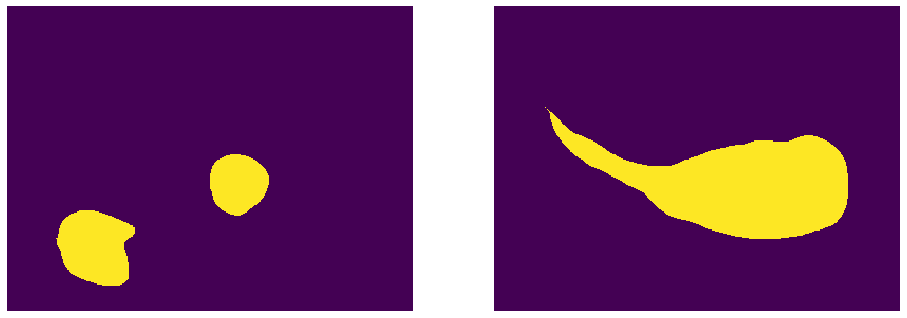

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(demo1)
ax[0].axis('off')
ax[1].imshow(demo2)
ax[1].axis('off')
plt.show()

## distance map for skimage

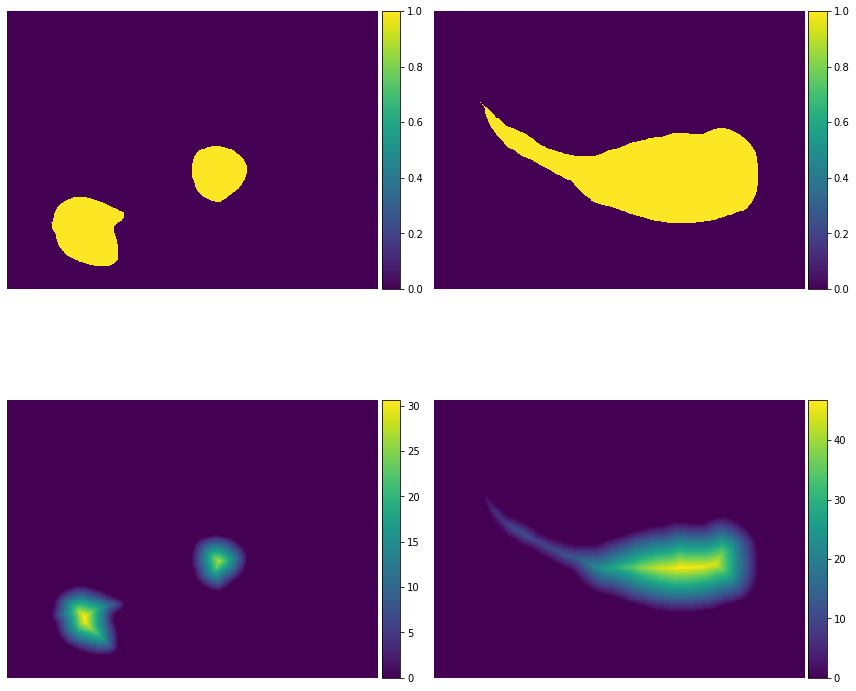

In [6]:
skimg_dsm_out1 = distance(demo1)
skimg_dsm_out2 = distance(demo2)

fig, ax = plt.subplots(2, 2, constrained_layout=False, figsize=(12, 12))

batch_demo1 = ax[0, 0].imshow(demo1)
ax[0, 0].axis('off')
colorbar(batch_demo1)


batch_demo2 = ax[0, 1].imshow(demo2)
ax[0, 1].axis('off')
colorbar(batch_demo2)

batch_out1 = ax[1, 0].imshow(skimg_dsm_out1)
ax[1, 0].axis('off')
colorbar(batch_out1)

batch_out2 = ax[1, 1].imshow(skimg_dsm_out2)
ax[1, 1].axis('off')
colorbar(batch_out2)

plt.tight_layout()
plt.show()

## disntance map for boundary loss

In [7]:
# refer to https://github.com/LIVIAETS/boundary-loss/blob/master/keras_loss.py

In [8]:
# calculate the distance map for single image
def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res

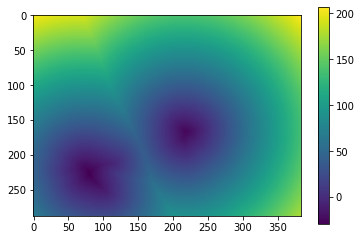

In [9]:
plt.imshow(calc_dist_map(demo1))
plt.colorbar()

In [10]:
# calculate the distance map for batch image
def calc_dist_map_batch(y_true):
    if not isinstance(y_true, np.ndarray):
        y_true = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true]).astype(np.float32)

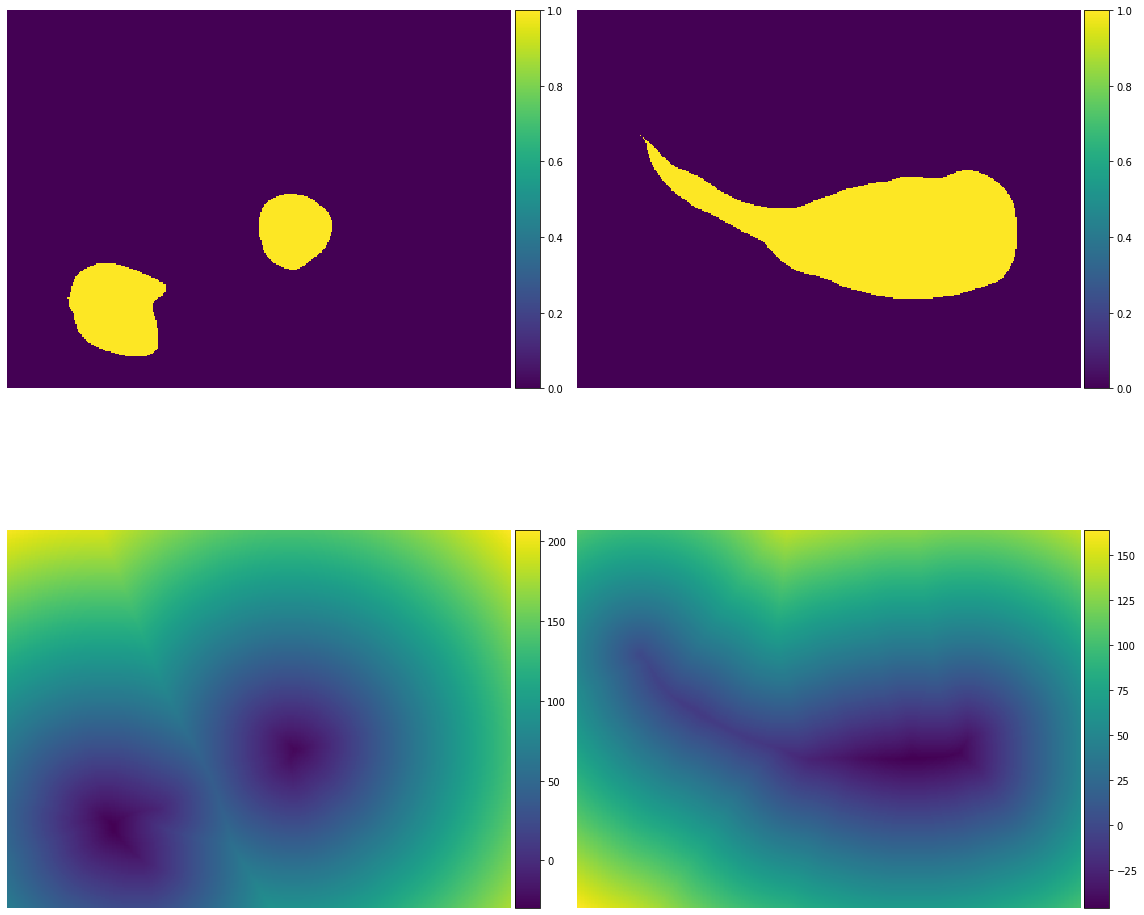

In [11]:
out_batch_demo = calc_dist_map_batch(batch_demo)
fig, ax = plt.subplots(2, 2, constrained_layout=False, figsize=(16, 16))

batch_demo1 = ax[0, 0].imshow(batch_demo[0])
ax[0, 0].axis('off')
colorbar(batch_demo1)

batch_demo2 = ax[0, 1].imshow(batch_demo[1])
ax[0, 1].axis('off')
colorbar(batch_demo2)

batch_out1 = ax[1, 0].imshow(out_batch_demo[0])
ax[1, 0].axis('off')
colorbar(batch_out1)

batch_out2 = ax[1, 1].imshow(out_batch_demo[1])
ax[1, 1].axis('off')
colorbar(batch_out2)

plt.tight_layout()
plt.show()

## Distance Map for "Distance Map Loss Penalty Term for Semantic Segmentation"

In [12]:
# refer to: https://openreview.net/pdf?id=B1eIcvS45V
# https://github.com/JunMa11/SegLoss/blob/71b14900e91ea9405d9705c95b451fc819f24c70/losses_pytorch/boundary_loss.py#L226

In [13]:
# calculate the distance map for single image
def calc_dist_map_for_penalty(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    
    if posmask.any():
        negmask = ~posmask
        pos_edt = distance(posmask)
        pos_edt = (np.max(pos_edt)-pos_edt)*posmask 
        neg_edt =  distance(negmask)
        neg_edt = (np.max(neg_edt)-neg_edt)*negmask
        res = pos_edt/np.max(pos_edt) + neg_edt/np.max(neg_edt)
    return res

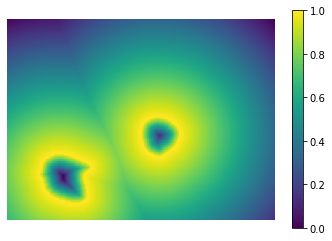

In [14]:
demo1_penalty = calc_dist_map_for_penalty(demo1)
plt.imshow(demo1_penalty)
plt.axis('off')
plt.colorbar()

In [15]:
def calc_dist_map_for_penalty_batch(seg):
    """
    GT.shape = (batch_size, x,y,z)
    only for binary segmentation
    """
    res = np.zeros(seg.shape)
    seg = seg.astype(np.bool)
    
    for i in range(seg.shape[0]):
        posmask = seg[i]
        negmask = ~posmask
        pos_edt = distance(posmask)
        pos_edt = (np.max(pos_edt)-pos_edt)*posmask 
        neg_edt =  distance(negmask)
        neg_edt = (np.max(neg_edt)-neg_edt)*negmask
        
        res[i] = pos_edt/np.max(pos_edt) + neg_edt/np.max(neg_edt)
    return res

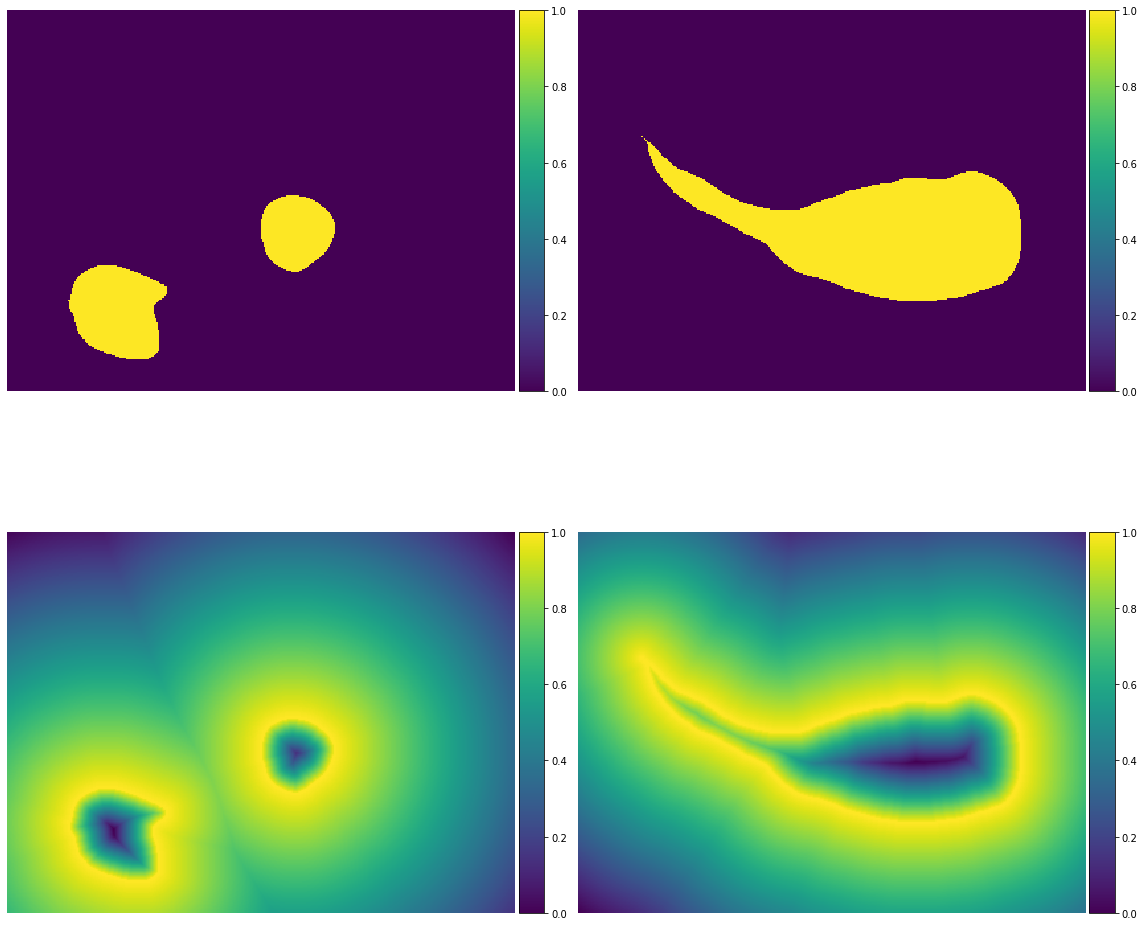

In [16]:
batch_out_for_penal = calc_dist_map_for_penalty_batch(batch_demo)

fig, ax = plt.subplots(2, 2, figsize=(16, 16))

batch_demo1 = ax[0, 0].imshow(batch_demo[0])
ax[0, 0].axis('off')
colorbar(batch_demo1)

batch_demo2 = ax[0, 1].imshow(batch_demo[1])
ax[0, 1].axis('off')
colorbar(batch_demo2)

batch_out1 = ax[1, 0].imshow(batch_out_for_penal[0])
ax[1, 0].axis('off')
colorbar(batch_out1)

batch_out2 = ax[1, 1].imshow(batch_out_for_penal[1])
ax[1, 1].axis('off')
colorbar(batch_out2)

plt.tight_layout()
plt.show()

## haudorff distance map 

In [17]:
# refer to https://arxiv.org/pdf/1904.10030v1.pdf  
# https://github.com/JunMa11/SegLoss/blob/71b14900e91ea9405d9705c95b451fc819f24c70/losses_pytorch/boundary_loss.py#L164

In [18]:
def calc_dist_map_for_hd(seg):
    res = np.zeros_like(seg.shape)
    posmask = seg.astype(np.bool)
    
    if posmask.any():
        negmask = ~posmask
        res = distance(posmask) + distance(negmask)
    return res

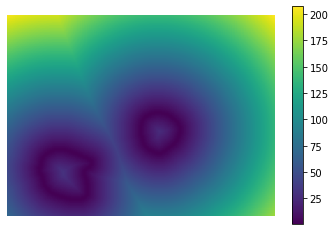

In [19]:
out = calc_dist_map_for_hd(demo1)
plt.imshow(out.squeeze())
plt.axis('off')
plt.colorbar()

In [20]:
def calc_dist_map_for_hd_batch(seg):
    res = np.zeros(seg.shape)
    seg = seg.astype(np.bool)
    
    for i in range(seg.shape[0]):
        posmask = seg[i]
        negmask = ~posmask
        res[i] = distance(posmask) + distance(negmask)
    return res

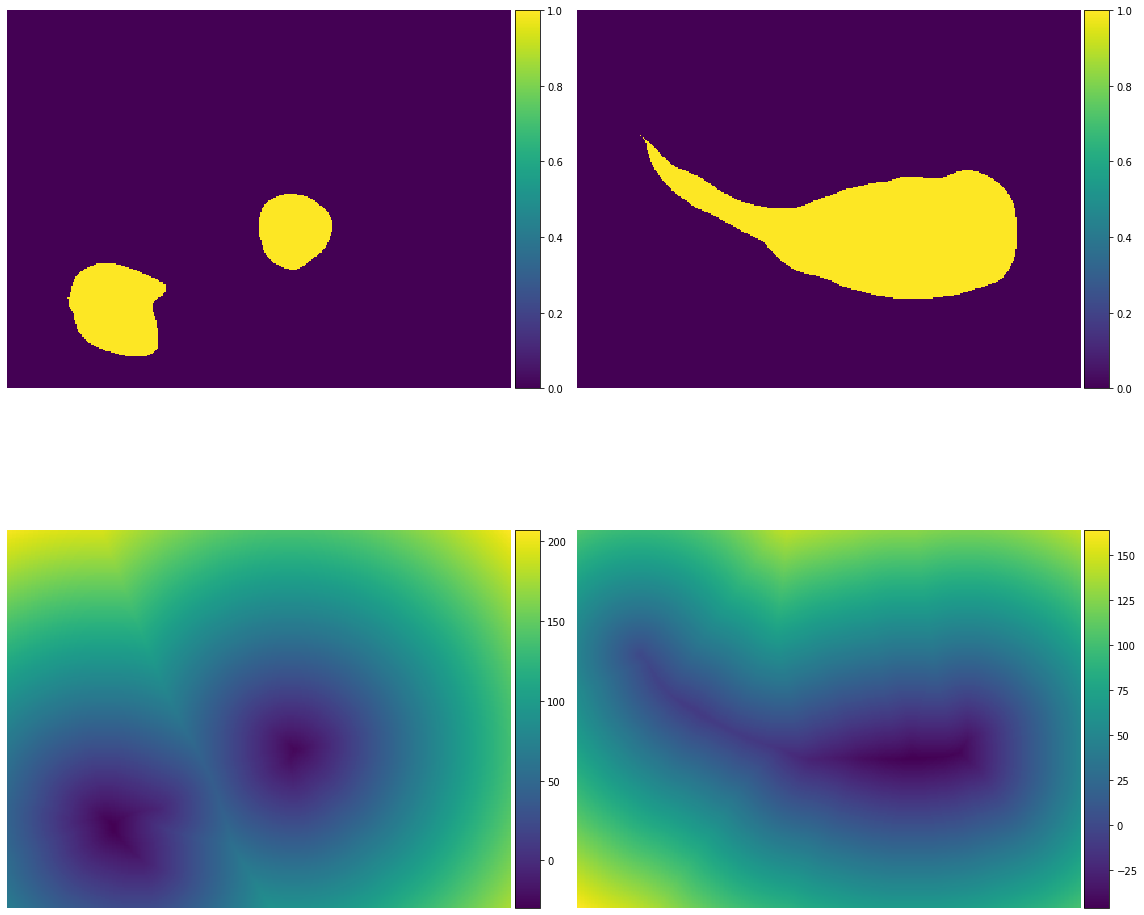

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

batch_demo1 = ax[0, 0].imshow(batch_demo[0])
ax[0, 0].axis('off')
colorbar(batch_demo1)

batch_demo2 = ax[0, 1].imshow(batch_demo[1])
ax[0, 1].axis('off')
colorbar(batch_demo2)

batch_out1 = ax[1, 0].imshow(out_batch_demo[0])
ax[1, 0].axis('off')
colorbar(batch_out1)

batch_out2 = ax[1, 1].imshow(out_batch_demo[1])
ax[1, 1].axis('off')
colorbar(batch_out2)

plt.tight_layout()
plt.show()

## computer sign distance function

In [22]:
# refer to: https://github.com/JunMa11/SegWithDistMap/blob/e0281f599feebf352d2c0eb9b24a4c4317bf4c87/code/utils/losses.py#L117

Signed Distance Map (SDM):

$$ 
  sdm(x)= 
  \begin{cases}
      -\inf\limits_{y \in G} |x-y|, &\ x \in G_{in} \\
      0,           &\ x \in G \\
      +\inf\limits_{y \in G} |x+y|, &\ x \in G_{out}
  \end{cases}
$$

In [23]:
def compute_sdf01(segmentation):
    """
    compute the signed distance map of binary mask
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the Signed Distance Map (SDM) 
    sdm(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation
    """
    # print(type(segmentation), segmentation.shape)

    segmentation = segmentation.astype(np.uint8)
    if len(segmentation.shape) == 4: # 3D image
        segmentation = np.expand_dims(segmentation, 1)
    normalized_sdf = np.zeros(segmentation.shape)
    if segmentation.shape[1] == 1:
        dis_id = 0
    else:
        dis_id = 1
    for b in range(segmentation.shape[0]): # batch size
        for c in range(dis_id, segmentation.shape[1]): # class_num
            # ignore background
            posmask = segmentation[b][c]
            negmask = ~posmask
            posdis = distance(posmask)
            negdis = distance(negmask)
            boundary = skimage_seg.find_boundaries(posmask, mode='inner').astype(np.uint8)
            sdf = negdis/np.max(negdis)/2 - posdis/np.max(posdis)/2 + 0.5
            sdf[boundary>0] = 0.5
            normalized_sdf[b][c] = sdf
    return normalized_sdf

In [24]:
out_sdf1 = compute_sdf01(np.expand_dims(batch_demo, 1))

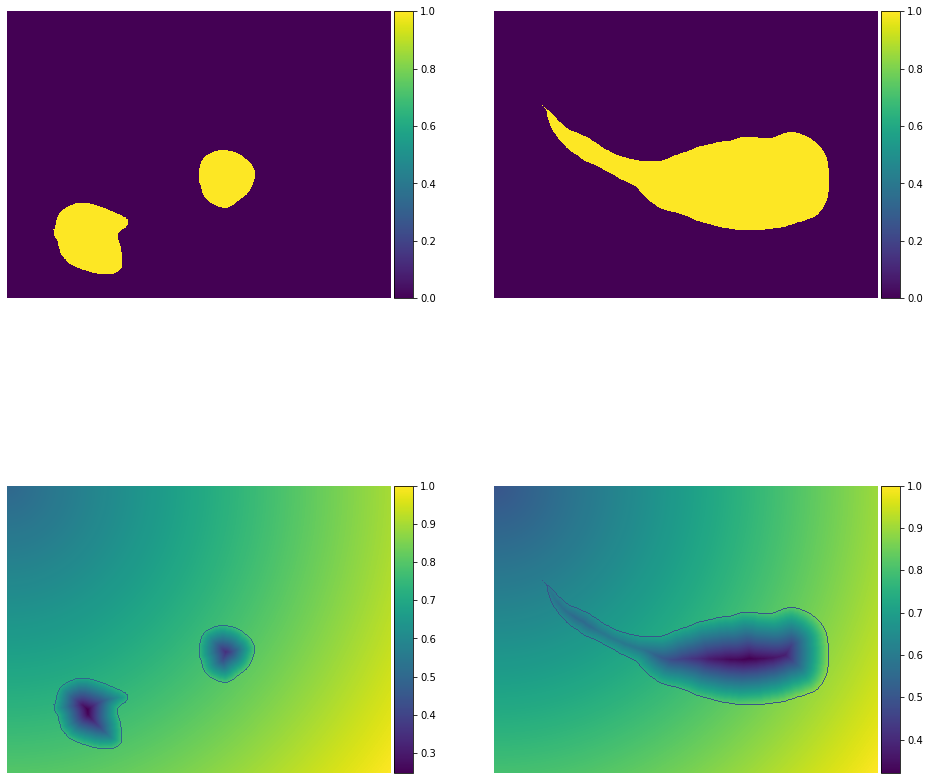

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

img1 = ax[0, 0].imshow(batch_demo[0].squeeze())
ax[0, 0].axis('off')
colorbar(img1)
img2 = ax[0, 1].imshow(batch_demo[1].squeeze())
ax[0, 1].axis('off')
colorbar(img2)
img3 = ax[1, 0].imshow(out_sdf1[0].squeeze())
ax[1, 0].axis('off')
colorbar(img3)
img4 = ax[1, 1].imshow(out_sdf1[1].squeeze())
ax[1, 1].axis('off')
colorbar(img4)

plt.show()

##  Compute signed distance map

In [26]:
# refer to: https://github.com/JunMa11/SegWithDistMap/blob/e0281f599feebf352d2c0eb9b24a4c4317bf4c87/code/utils/losses.py#L151

In [27]:
def compute_sdf1_1(segmentation):
    """
    compute the signed distance map of binary mask
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the Signed Distance Map (SDM) 
    sdm(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation
    """
    # print(type(segmentation), segmentation.shape)

    segmentation = segmentation.astype(np.uint8)
    if len(segmentation.shape) == 4: # 3D image
        segmentation = np.expand_dims(segmentation, 1)
    normalized_sdf = np.zeros(segmentation.shape)
    if segmentation.shape[1] == 1:
        dis_id = 0
    else:
        dis_id = 1
    for b in range(segmentation.shape[0]): # batch size
        for c in range(dis_id, segmentation.shape[1]): # class_num
            # ignore background
            posmask = segmentation[b][c]
            negmask = ~posmask
            posdis = distance(posmask)
            negdis = distance(negmask)
            boundary = skimage_seg.find_boundaries(posmask, mode='inner').astype(np.uint8)
            sdf = negdis/np.max(negdis) - posdis/np.max(posdis)
            sdf[boundary>0] = 0
            normalized_sdf[b][c] = sdf
    return normalized_sdf

In [28]:
out_sdf2 = compute_sdf1_1(np.expand_dims(batch_demo, 1))

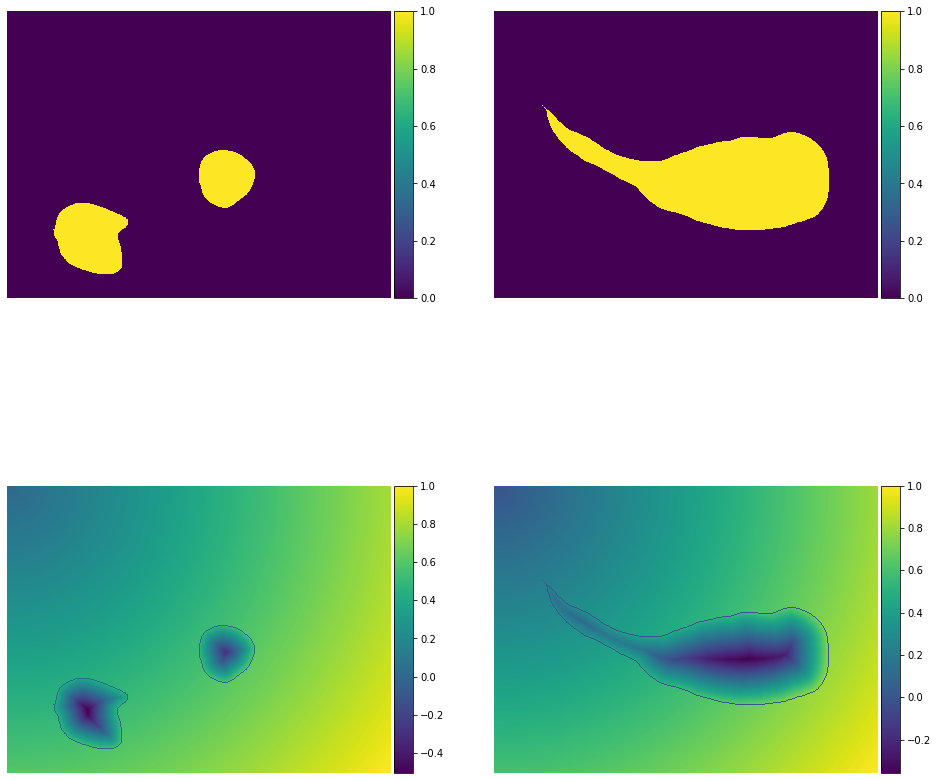

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

img1 = ax[0, 0].imshow(batch_demo[0].squeeze())
ax[0, 0].axis('off')
colorbar(img1)
img2 = ax[0, 1].imshow(batch_demo[1].squeeze())
ax[0, 1].axis('off')
colorbar(img2)
img3 = ax[1, 0].imshow(out_sdf2[0].squeeze())
ax[1, 0].axis('off')
colorbar(img3)
img4 = ax[1, 1].imshow(out_sdf2[1].squeeze())
ax[1, 1].axis('off')
colorbar(img4)

plt.show()

##  Compute signed distance map

In [30]:
# refer to: https://github.com/JunMa11/SegWithDistMap/blob/e0281f599feebf352d2c0eb9b24a4c4317bf4c87/code/utils/losses.py#L185

In [31]:
def compute_fore_dist(segmentation):
    """
    compute the foreground of binary mask
    input: segmentation, shape = (batch_size, class, x, y, z)
    output: the Signed Distance Map (SDM) 
    sdm(x) = 0; x in segmentation boundary
             -inf|x-y|; x in segmentation
             +inf|x-y|; x out of segmentation
    """
    # print(type(segmentation), segmentation.shape)

    segmentation = segmentation.astype(np.uint8)
    if len(segmentation.shape) == 4: # 3D image
        segmentation = np.expand_dims(segmentation, 1)
    normalized_sdf = np.zeros(segmentation.shape)
    if segmentation.shape[1] == 1:
        dis_id = 0
    else:
        dis_id = 1
    for b in range(segmentation.shape[0]): # batch size
        for c in range(dis_id, segmentation.shape[1]): # class_num
            # ignore background
            posmask = segmentation[b][c]
            posdis = distance(posmask)
            normalized_sdf[b][c] = posdis/np.max(posdis)
    return normalized_sdf

In [32]:
out_sdf3 = compute_fore_dist(np.expand_dims(batch_demo, 1))

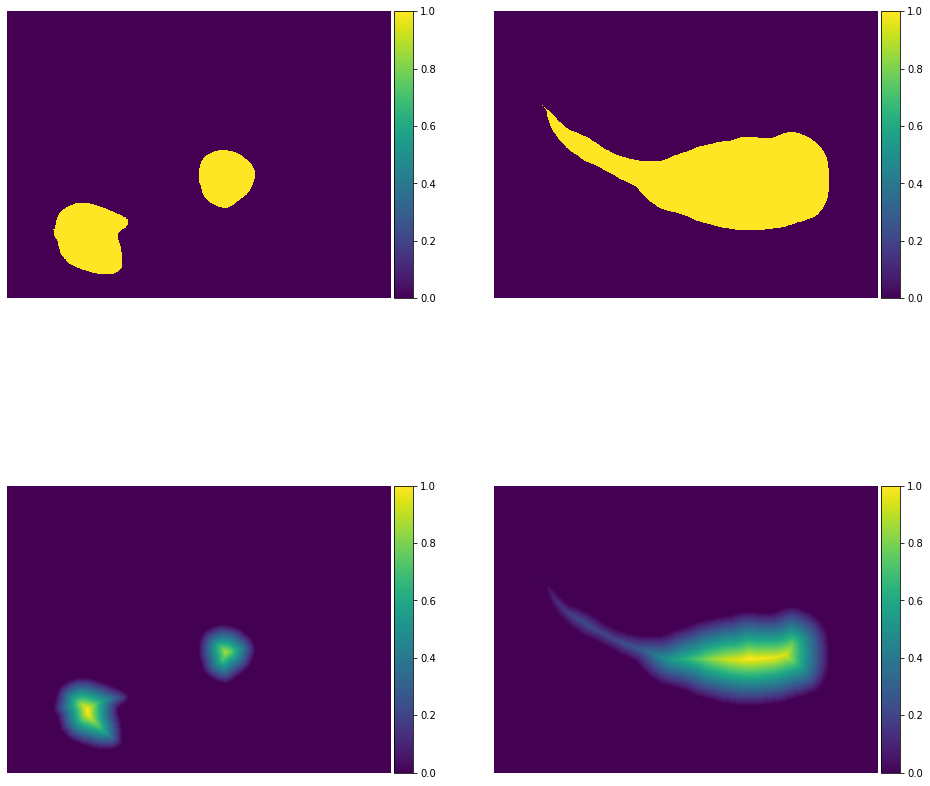

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

img1 = ax[0, 0].imshow(batch_demo[0].squeeze())
ax[0, 0].axis('off')
colorbar(img1)
img2 = ax[0, 1].imshow(batch_demo[1].squeeze())
ax[0, 1].axis('off')
colorbar(img2)
img3 = ax[1, 0].imshow(out_sdf3[0].squeeze())
ax[1, 0].axis('off')
colorbar(img3)
img4 = ax[1, 1].imshow(out_sdf3[1].squeeze())
ax[1, 1].axis('off')
colorbar(img4)

plt.show()